**Model, Training, and Validation Code**

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
import random
import numpy as np
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
from transformers import BertModel
from transformers import BertTokenizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pre-processing
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# setting seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
labels = {"negative": 0, "positive": 1}


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df["sentiment"]]
        self.texts = [
            tokenizer(
                text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )
            for text in df["review"]
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


*Downloading data*

In [ ]:
datapath = 'drive/MyDrive/IMDB Dataset.csv'
df = pd.read_csv(datapath)
df_processed = df

*Without pre-processing data splitting code*

In [ ]:
X = df["review"]
y = df["sentiment"]

train_count = round(0.7 * (df.shape[0] / 2)) * 2
train_percentage = train_count / df.shape[0]

X_train, X, y_train, y = train_test_split(
    X, y, stratify=y, train_size=train_percentage, random_state=SEED
)

# train here refers to test set
train_count = round((2 / 3) * (df.shape[0] / 2)) * 2
train_percentage = train_count / df.shape[0]

X_test, X_val, y_test, y_val = train_test_split(
    X, y, stratify=y, train_size=train_percentage, random_state=SEED
)

df_train = pd.concat([X_train, y_train], axis=1, ignore_index=False)
df_val = pd.concat([X_val, y_val], axis=1, ignore_index=False)
df_test = pd.concat([X_test, y_test], axis=1, ignore_index=False)

print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())


positive    17500
negative    17500
Name: sentiment, dtype: int64
positive    2500
negative    2500
Name: sentiment, dtype: int64
negative    5000
positive    5000
Name: sentiment, dtype: int64


*With pre-processing data splitting code*

In [ ]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")


p = re.compile(r"[^\w\s]+")
df["review"] = [p.sub("", x) for x in df["review"].tolist()]

stop_words = set(stopwords.words("english"))
df_processed["review"] = df_processed["review"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop_words)])
)

df_processed["review"] = df_processed["review"].str.lower()

lemmatizer = WordNetLemmatizer()


def pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None


def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


df_processed["review"] = df_processed["review"].apply(lemmatize_sentence)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X = df_processed["review"]
y = df_processed["sentiment"]

train_count = round(0.7 * (df_processed.shape[0] / 2)) * 2
train_percentage = train_count / df_processed.shape[0]

X_train_processed, X, y_train_processed, y = train_test_split(
    X, y, stratify=y, train_size=train_percentage, random_state=SEED
)

# train here refers to test set
train_count = round((2 / 3) * (df_processed.shape[0] / 2)) * 2
train_percentage = train_count / df_processed.shape[0]

X_test_processed, X_val_processed, y_test_processed, y_val_processed = train_test_split(
    X, y, stratify=y, train_size=train_percentage, random_state=SEED
)

df_train_processed = pd.concat([X_train_processed, y_train_processed], axis=1, ignore_index=False)
df_val_processed = pd.concat([X_val_processed, y_val_processed], axis=1, ignore_index=False)
df_test_processed = pd.concat([X_test_processed, y_test_processed], axis=1, ignore_index=False)

print(y_train_processed.value_counts())
print(y_val_processed.value_counts())
print(y_test_processed.value_counts())


positive    17500
negative    17500
Name: sentiment, dtype: int64
positive    2500
negative    2500
Name: sentiment, dtype: int64
negative    5000
positive    5000
Name: sentiment, dtype: int64


*For testing*

In [ ]:
y_test_num = y_test.copy()
y_test_num.replace("negative", 0, inplace=True)
y_test_num.replace("positive", 1, inplace=True)

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(dropout)

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(
            input_ids=input_id, attention_mask=mask, return_dict=False
        )
        dropout_output = self.dropout(pooled_output)
        out = self.linear_relu_stack(dropout_output)
        out = torch.sigmoid(out)

        return out


In [ ]:
loss_fn = nn.BCELoss()

In [ ]:
batch_s = 8


def train(
    model,
    train_data,
    val_data,
    learning_rate,
    START_EPOCH,
    MAX_EPOCHS,
    loss_fn,
    acc_diff,
    path,
):
    torch.manual_seed(SEED)

    def seed_worker(worker_id):
        np.random.seed(SEED)
        random.seed(SEED)

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(
        train,
        batch_size=batch_s,
        shuffle=True,
        worker_init_fn=seed_worker,
    )
    val_dataloader = torch.utils.data.DataLoader(
        val,
        batch_size=batch_s,
        worker_init_fn=seed_worker,
    )

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = loss_fn
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    prev_acc = 0
    for epoch_num in range(START_EPOCH, MAX_EPOCHS + 1):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)
            output = torch.flatten(output)

            batch_loss = criterion(output, train_label.to(torch.float32))
            total_loss_train += batch_loss.item()

            output = torch.round(output)
            acc = (output == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_id = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)
                output = torch.flatten(output)

                batch_loss = criterion(output, val_label.to(torch.float32))
                total_loss_val += batch_loss.item()

                output = torch.round(output)
                acc = (output == val_label).sum().item()
                total_acc_val += acc
        results = f"Epochs: {epoch_num} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}"
        print(results)
        with open(f"{path}{learning_rate}_epoch{epoch_num}.txt", "w") as text_file:
            text_file.write(results)
        torch.save(model, f"{path}{learning_rate}_epoch{epoch_num}")

        if (total_acc_val / len(val_data)) - prev_acc <= acc_diff:
            return (total_loss_val / len(val_data), total_acc_val / len(val_data))
        prev_acc = total_acc_val / len(val_data)


Trying learning rates: [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

In [ ]:
START_EPOCH = 1 # inclusive
MAX_EPOCHS = 50 # inclusive
acc_diff = -0.04 # -4%
path = '/content/drive/MyDrive/models/no_preprocessing/' # or /preprocessing

for LR in [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]:
    model = BertClassifier()
    train(model, df_train, df_val, LR, START_EPOCH, MAX_EPOCHS, loss_fn, acc_diff, path)

Adding 2 more learning rates to find perfect value: [5e-5, 5e-6]

In [ ]:
START_EPOCH = 1 # inclusive
MAX_EPOCHS = 50 # inclusive
acc_diff = -0.04 # -4%
path = '/content/drive/MyDrive/models/no_preprocessing/' # or /preprocessing

for LR in [5e-5, 5e-6]: # learning rates added after initial runs for fine tuning
    model = BertClassifier() # since 1e5 had the best accuracy
    train(model, df_train, df_val, LR, START_EPOCH, MAX_EPOCHS, loss_fn, acc_diff, path)

Example of loading a previous model and continuing training

In [ ]:
START_EPOCH = 12 # inclusive
MAX_EPOCHS = 50 # inclusive
acc_diff = -0.04 # -4%
path = '/content/drive/MyDrive/models/no_preprocessing/' # or /preprocessing

model = torch.load(f'{path}1e-06_epoch11')
train(model, df_train, df_val, LR, START_EPOCH, MAX_EPOCHS, loss_fn, acc_diff, path)

**Without pre-processing results**

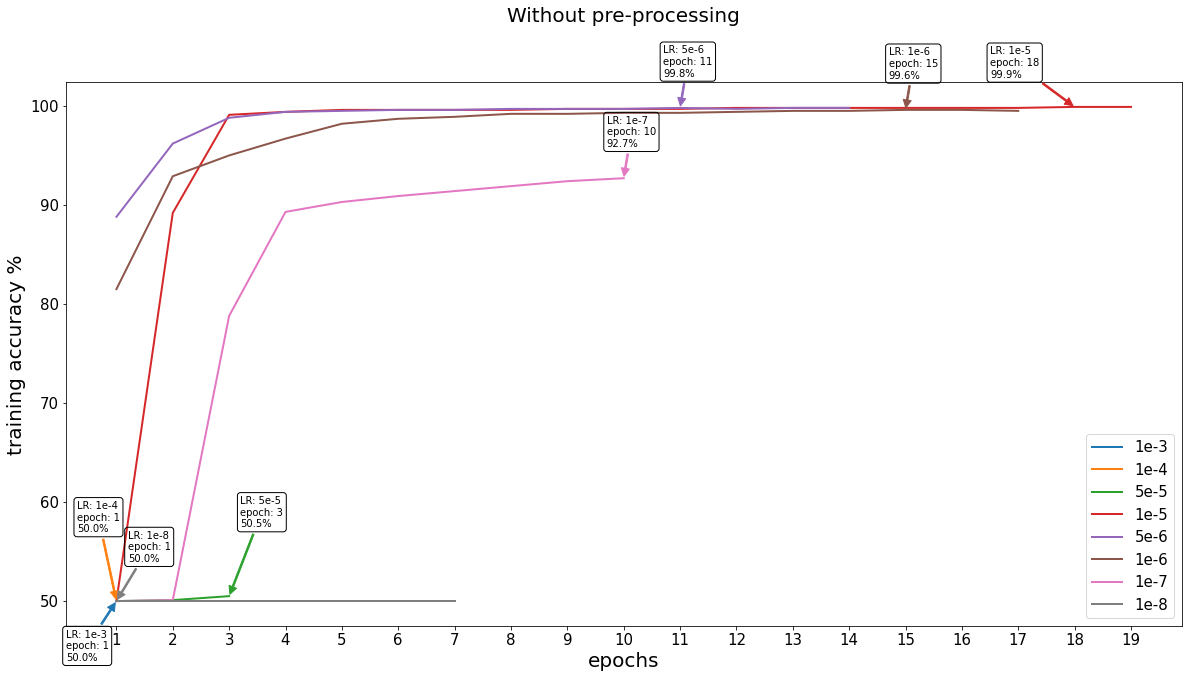

In [ ]:
main_label = "Without pre-processing"
sub_label = ["1e-3", "1e-4", "5e-5", "1e-5", "5e-6", "1e-6", "1e-7", "1e-8"]
results = [
    [50.0, 50.0, 50.0],
    [50.0, 50.0, 50.0, 50.0, 50.0, 50.0],
    [50.0, 50.1, 50.5],
    [50.0, 89.2, 99.1, 99.4, 99.6, 99.6, 99.6, 99.6, 99.7, 99.7, 99.7, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.9, 99.9],
    [88.8, 96.2, 98.8, 99.4, 99.5, 99.6, 99.6, 99.7, 99.7, 99.7, 99.8, 99.7, 99.8, 99.8],
    [81.5, 92.9, 95.0, 96.7, 98.2, 98.7, 98.9, 99.2, 99.2, 99.3, 99.3, 99.4, 99.5, 99.5, 99.6, 99.6, 99.5],
    [50.0, 50.1, 78.8, 89.3, 90.3, 90.9, 91.4, 91.9, 92.4, 92.7],
    [50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("training accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    if sub_label[i] == "1e-3":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.9, ymax - 6),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-4":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.7, ymax + 7),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "5e-5":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax + 0.2, ymax + 7),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-5":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 1.5, ymax + 3),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-8":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax + 0.2, ymax + 4),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    else:
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.3, ymax + 3.2),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
plt.legend(fontsize=15)

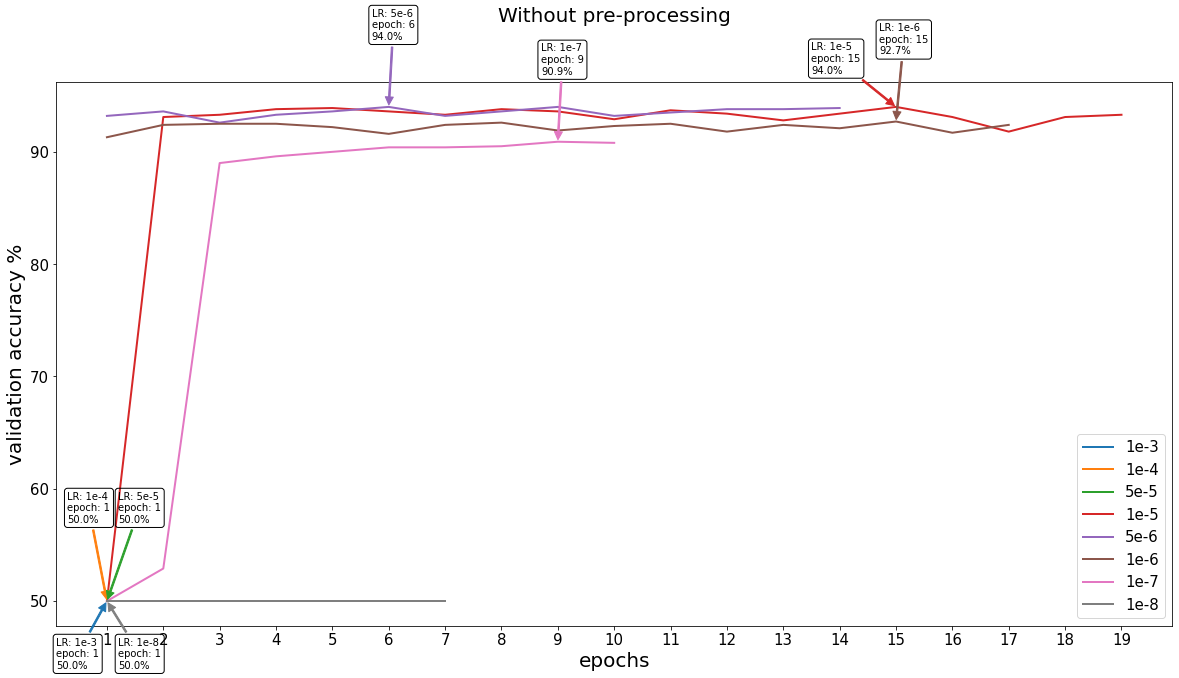

In [ ]:
main_label = "Without pre-processing"
sub_label = ["1e-3", "1e-4", "5e-5", "1e-5", "5e-6", "1e-6", "1e-7", "1e-8"]
results = [
    [50.0, 50.0, 50.0],
    [50.0, 50.0, 50.0, 50.0, 50.0, 50.0],
    [50.0, 50.0, 50.0],
    [50.0, 93.1, 93.3, 93.8, 93.9, 93.6, 93.3, 93.8, 93.6, 92.9, 93.7, 93.4, 92.8, 93.4, 94.0, 93.1, 91.8, 93.1, 93.3],
    [93.2, 93.6, 92.6, 93.3, 93.6, 94.0, 93.2, 93.6, 94.0, 93.2, 93.5, 93.8, 93.8, 93.9],
    [91.3, 92.4, 92.5, 92.5, 92.2, 91.6, 92.4, 92.6, 91.9, 92.3, 92.5, 91.8, 92.4, 92.1, 92.7, 91.7, 92.4],
    [50.0, 52.9, 89.0, 89.6, 90.0, 90.4, 90.4, 90.5, 90.9, 90.8],
    [50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("validation accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    if sub_label[i] == "1e-3":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.9, ymax - 6),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-4":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.7, ymax + 7),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "5e-5":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax + 0.2, ymax + 7),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-5":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 1.5, ymax + 3),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-8":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax + 0.2, ymax - 6),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    else:
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.3, ymax + 6),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
plt.legend(fontsize=15)

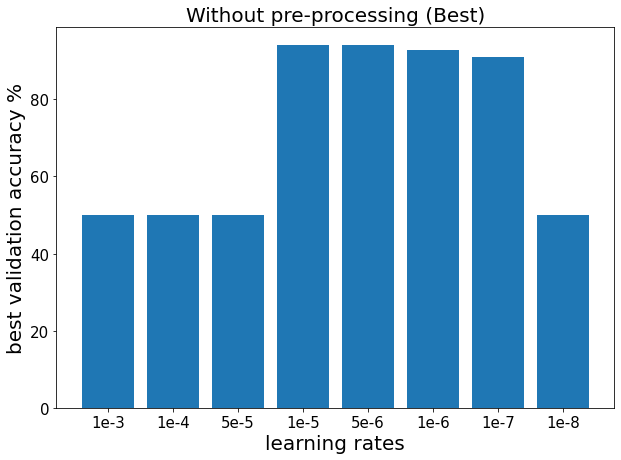

In [ ]:
main_label = "Without pre-processing (Best)"
x_axis = ["1e-3", "1e-4", "5e-5", "1e-5", "5e-6", "1e-6", "1e-7", "1e-8"]
y_axis = []
for i in range(len(results)):
    ymax = max(results[i])
    y_axis.append(ymax)
fig, ax = plt.subplots(figsize=(10, 7))
ax.tick_params(axis="both", which="major", labelsize=15)
plt.bar(x_axis, y_axis)
plt.title(main_label, fontsize=20)
plt.xlabel("learning rates", fontsize=20)
plt.ylabel("best validation accuracy %", fontsize=20)
plt.show()


Models with the best validation accuracy are using learning rates 1e-5 and 5e-6 at 94.0%, will pick 5e-6 epoch 6 over 1e-5 epoch 15 as it has a lower validation loss of 0.031 vs 0.040.

*Testing best model (5e-6 epoch 6)*

In [ ]:
batch_s = 8
torch.manual_seed(SEED)
def seed_worker(worker_id):
    np.random.seed(SEED)
    random.seed(SEED)

test = Dataset(df_test)
test_dataloader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_s,
    worker_init_fn=seed_worker,
)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

path = '/content/drive/MyDrive/models/no_preprocessing/'
model = torch.load(f'{path}5e-06_epoch6')
model.eval()
all_y_pred = []
for test_input, test_label in test_dataloader:
    test_label = test_label.to(device)
    mask = test_input["attention_mask"].to(device)
    input_id = test_input["input_ids"].squeeze(1).to(device)
    with torch.no_grad():
        y_pred = model(input_id, mask)
    y_pred = torch.flatten(y_pred)
    y_pred = torch.round(y_pred)
    all_y_pred.append(y_pred)
    
all_y_pred = torch.cat(all_y_pred, dim=0)


Accuracy: 93.78%
Precision: 0.931
recall: 0.946
specificity: 0.930
f1-score: 0.938


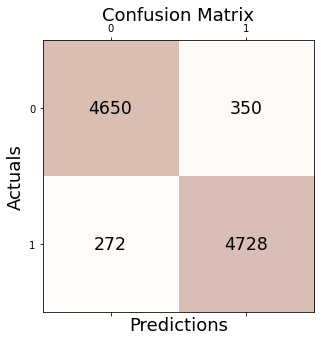

In [ ]:
y_pred = all_y_pred.cpu()

print(f"Accuracy: {metrics.accuracy_score(y_test_num, y_pred)*100:.2f}%")

scores_pos = metrics.precision_recall_fscore_support(
    y_test_num, y_pred, average=None, labels=[1]
)
precision = scores_pos[0][0]
recall = scores_pos[1][0]
f1score = scores_pos[2][0]
specificity = metrics.precision_recall_fscore_support(
    y_test_num, y_pred, average=None, labels=[0]
)[1][
    0
]  # specificity is recall of negative class

print(f"Precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"specificity: {specificity:.3f}")
print(f"f1-score: {f1score:.3f}")

conf_matrix = metrics.confusion_matrix(y_true=y_test_num, y_pred=y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(
            x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large"
        )
plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()


**With pre-processing**

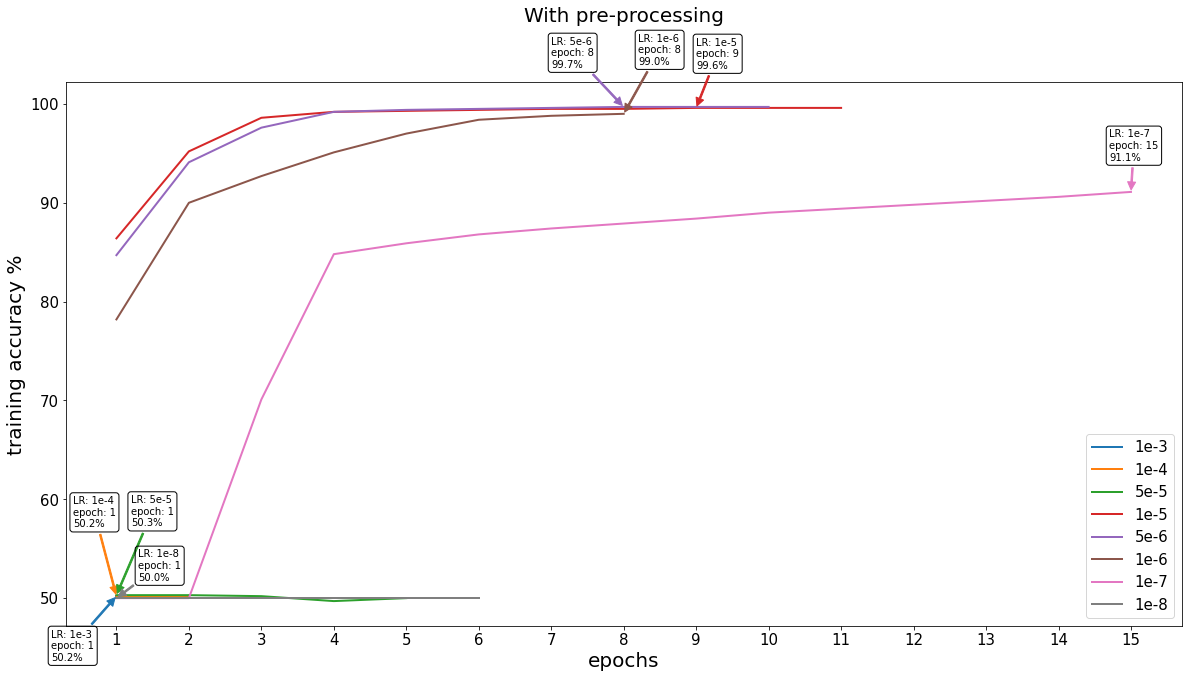

In [ ]:
main_label = "With pre-processing"
sub_label = ["1e-3", "1e-4", "5e-5", "1e-5", "5e-6", "1e-6", "1e-7", "1e-8"]
results = [
    [50.2, 50.2],
    [50.2, 50.1],
    [50.3, 50.3, 50.2, 49.7, 50.0],
    [86.4, 95.2, 98.6, 99.2, 99.3, 99.4, 99.5, 99.5, 99.6, 99.6, 99.6],
    [84.7, 94.1, 97.6, 99.2, 99.4, 99.5, 99.6, 99.7, 99.7, 99.7],
    [78.2, 90.0, 92.7, 95.1, 97.0, 98.4, 98.8, 99.0],
    [50.0, 50.0, 70.1, 84.8, 85.9, 86.8, 87.4, 87.9, 88.4, 89.0, 89.4, 89.8, 90.2, 90.6, 91.1],
    [50.0, 50.0, 50.0, 50.0, 50.0, 50.0],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("training accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    if sub_label[i] == "1e-3":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.9, ymax - 6.5),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-4":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.6, ymax + 7),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "5e-5":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax + 0.2, ymax + 7),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-5":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax, ymax + 4),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "5e-6":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 1, ymax + 4),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-6":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax + 0.2, ymax + 5),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-8":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax + 0.3, ymax + 1.8),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    else:
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.3, ymax + 3.2),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
plt.legend(fontsize=15)

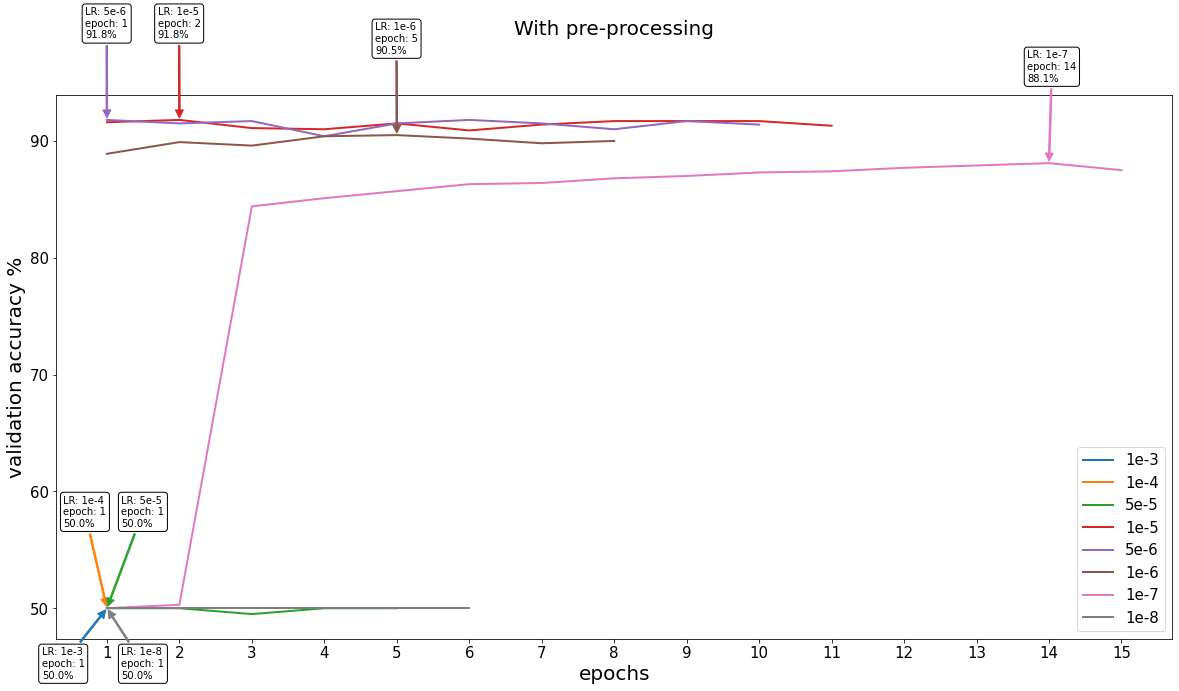

In [ ]:
main_label = "With pre-processing"
sub_label = ["1e-3", "1e-4", "5e-5", "1e-5", "5e-6", "1e-6", "1e-7", "1e-8"]
results = [
    [50.0, 50.0],
    [50.0, 50.0],
    [50.0, 50.0, 49.5, 50.0, 50.0],
    [91.6, 91.8, 91.1, 91.0, 91.5, 90.9, 91.4, 91.7, 91.7, 91.7, 91.3],
    [91.8, 91.5, 91.7, 90.4, 91.5, 91.8, 91.5, 91.0, 91.7, 91.4],
    [88.9, 89.9, 89.6, 90.4, 90.5, 90.2, 89.8, 90.0],
    [50.0, 50.3, 84.4, 85.1, 85.7, 86.3, 86.4, 86.8, 87.0, 87.3, 87.4, 87.7, 87.9, 88.1, 87.5],
    [50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("validation accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    if sub_label[i] == "1e-3":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.9, ymax - 6),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-4":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.6, ymax + 7),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "5e-5":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax + 0.2, ymax + 7),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    elif sub_label[i] == "1e-8":
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax + 0.2, ymax - 6),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
    else:
        ax.annotate(
            f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
            fontsize=10,
            xy=(xmax, ymax),
            xytext=(xmax - 0.3, ymax + 7),
            bbox=dict(boxstyle="round", fc="none", ec="black"),
            arrowprops=dict(
                arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
                color=p[0].get_color(),
            ),
        )
plt.legend(fontsize=15)


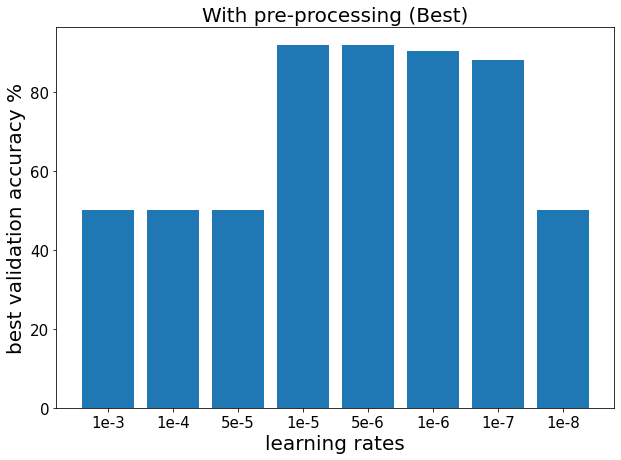

In [ ]:
main_label = "With pre-processing (Best)"
x_axis = ["1e-3", "1e-4", "5e-5", "1e-5", "5e-6", "1e-6", "1e-7", "1e-8"]
y_axis = []
for i in range(len(results)):
    ymax = max(results[i])
    y_axis.append(ymax)
fig, ax = plt.subplots(figsize=(10, 7))
ax.tick_params(axis="both", which="major", labelsize=15)
plt.bar(x_axis, y_axis)
plt.title(main_label, fontsize=20)
plt.xlabel("learning rates", fontsize=20)
plt.ylabel("best validation accuracy %", fontsize=20)
plt.show()


Models with the best validation accuracy are using learning rates 1e-5 and 5e-6 at 91.8%, will pick 1e-5 epoch 2 over 5e-6 epoch 1 as it has a lower validation loss of 0.027 vs 0.028

*Testing best model (1e-5 epoch 2)*

In [ ]:
batch_s = 8
torch.manual_seed(SEED)
def seed_worker(worker_id):
    np.random.seed(SEED)
    random.seed(SEED)

test = Dataset(df_test)
test_dataloader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_s,
    worker_init_fn=seed_worker,
)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

path = '/content/drive/MyDrive/models/preprocessing/'
model = torch.load(f'{path}1e-05_epoch2')
model.eval()
all_y_pred = []
for test_input, test_label in test_dataloader:
    test_label = test_label.to(device)
    mask = test_input["attention_mask"].to(device)
    input_id = test_input["input_ids"].squeeze(1).to(device)
    with torch.no_grad():
        y_pred = model(input_id, mask)
    y_pred = torch.flatten(y_pred)
    y_pred = torch.round(y_pred)
    all_y_pred.append(y_pred)
    
all_y_pred = torch.cat(all_y_pred, dim=0)


Accuracy: 91.45%
Precision: 0.932
recall: 0.894
specificity: 0.935
f1-score: 0.913


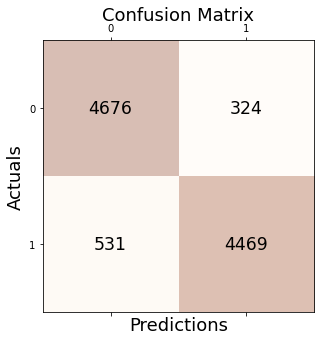

In [ ]:
y_pred = all_y_pred.cpu()

print(f"Accuracy: {metrics.accuracy_score(y_test_num, y_pred)*100:.2f}%")

scores_pos = metrics.precision_recall_fscore_support(
    y_test_num, y_pred, average=None, labels=[1]
)
precision = scores_pos[0][0]
recall = scores_pos[1][0]
f1score = scores_pos[2][0]
specificity = metrics.precision_recall_fscore_support(
    y_test_num, y_pred, average=None, labels=[0]
)[1][
    0
]  # specificity is recall of negative class

print(f"Precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"specificity: {specificity:.3f}")
print(f"f1-score: {f1score:.3f}")

conf_matrix = metrics.confusion_matrix(y_true=y_test_num, y_pred=y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(
            x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large"
        )
plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()


Without pre-processing: 93.78%  
With pre-processing: 91.45%

Using pre-processing resulted in lower accuracy, implying we stripped the data of useful information that had some indication whether the review was positive or negative.

**Bonus** *(without pre-processing)*

Only difference between previous code is modifying `self.linear_relu_stack` in the BertClassifier.  
Only ran on learning rates: [5e-5, 1e-5, 5e-6]

In [ ]:
# Add 1024
self.linear_relu_stack = nn.Sequential(
    nn.Linear(768, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)

# Add 32
self.linear_relu_stack = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)

# Remove 512
self.linear_relu_stack = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)

# Remove 64
self.linear_relu_stack = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)

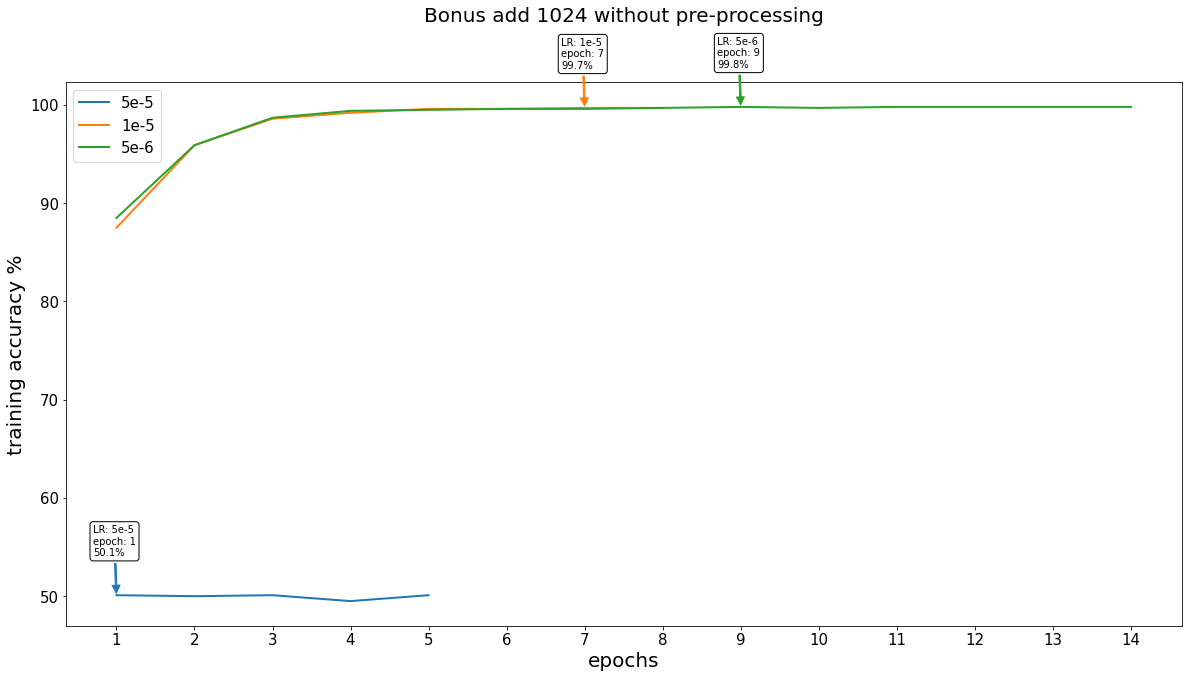

In [ ]:
main_label = "Bonus add 1024 without pre-processing"
sub_label = ["5e-5", "1e-5", "5e-6"]
results = [
    [50.1, 50.0, 50.1, 49.5, 50.1],
    [87.5, 95.9, 98.6, 99.2, 99.6, 99.6, 99.7, 99.7],
    [88.5, 95.9, 98.7, 99.4, 99.5, 99.6, 99.6, 99.7, 99.8, 99.7, 99.8, 99.8, 99.8, 99.8],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("training accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    ax.annotate(
        f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
        fontsize=10,
        xy=(xmax, ymax),
        xytext=(xmax - 0.3, ymax + 4),
        bbox=dict(boxstyle="round", fc="none", ec="black"),
        arrowprops=dict(
            arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
            color=p[0].get_color(),
        ),
    )
plt.legend(fontsize=15)


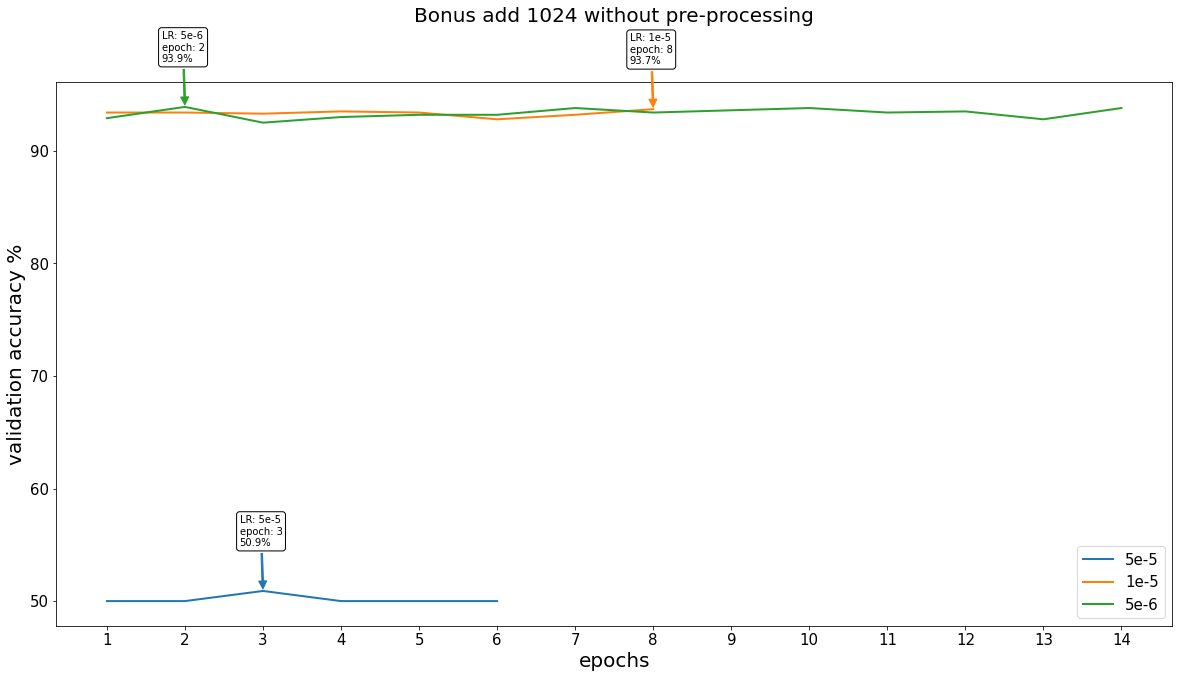

In [ ]:
main_label = "Bonus add 1024 without pre-processing"
sub_label = ["5e-5", "1e-5", "5e-6"]
results = [
    [50.0, 50.0, 50.9, 50.0, 50.0, 50.0],
    [93.4, 93.4, 93.3, 93.5, 93.4, 92.8, 93.2, 93.7],
    [92.9, 93.9, 92.5, 93.0, 93.2, 93.2, 93.8, 93.4, 93.6, 93.8, 93.4, 93.5, 92.8, 93.8],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("validation accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    ax.annotate(
        f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
        fontsize=10,
        xy=(xmax, ymax),
        xytext=(xmax - 0.3, ymax + 4),
        bbox=dict(boxstyle="round", fc="none", ec="black"),
        arrowprops=dict(
            arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
            color=p[0].get_color(),
        ),
    )
plt.legend(fontsize=15)


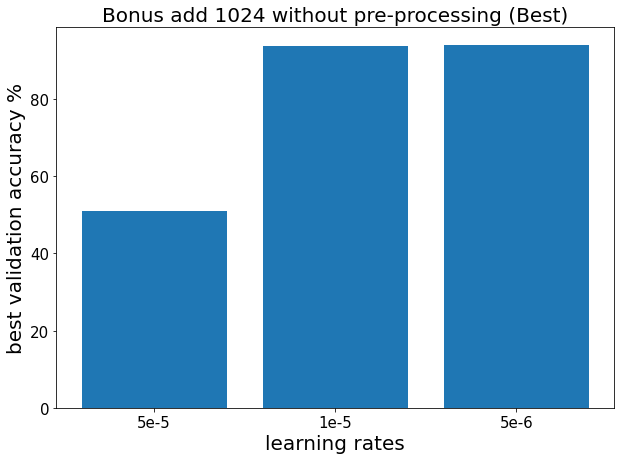

In [ ]:
main_label = "Bonus add 1024 without pre-processing (Best)"
x_axis = ["5e-5", "1e-5", "5e-6"]
y_axis = []
for i in range(len(results)):
    ymax = max(results[i])
    y_axis.append(ymax)
fig, ax = plt.subplots(figsize=(10, 7))
ax.tick_params(axis="both", which="major", labelsize=15)
plt.bar(x_axis, y_axis)
plt.title(main_label, fontsize=20)
plt.xlabel("learning rates", fontsize=20)
plt.ylabel("best validation accuracy %", fontsize=20)
plt.show()


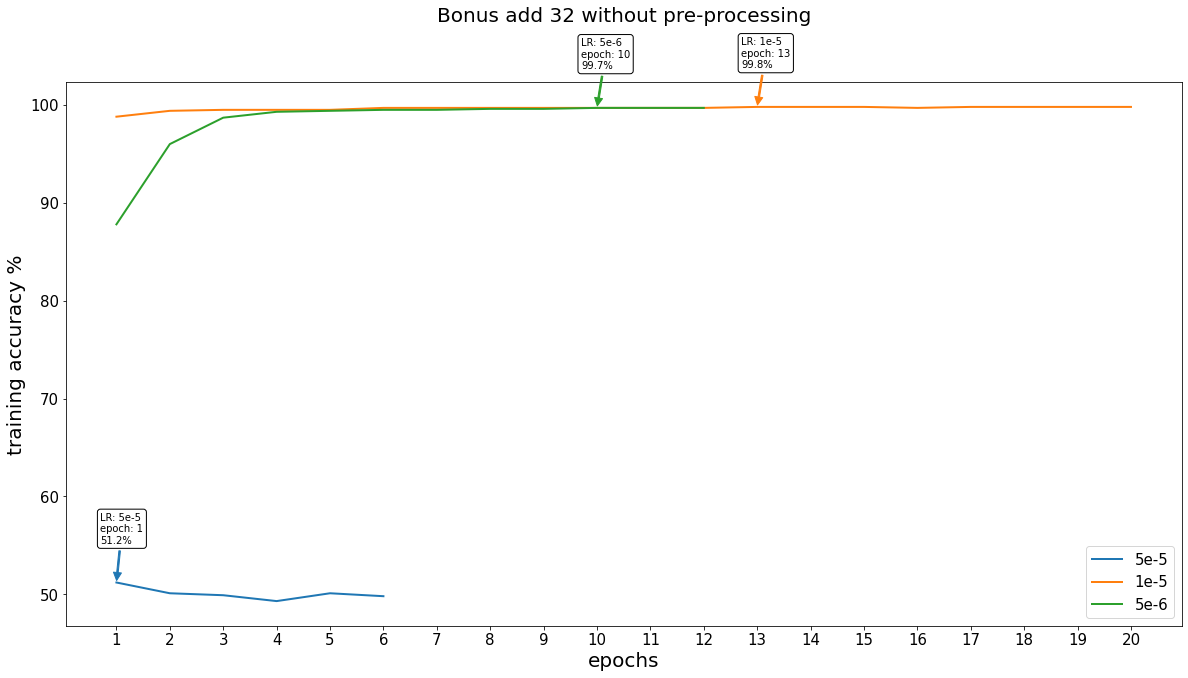

In [ ]:
main_label = "Bonus add 32 without pre-processing"
sub_label = ["5e-5", "1e-5", "5e-6"]
results = [
    [51.2, 50.1, 49.9, 49.3, 50.1, 49.8],
    [98.8, 99.4, 99.5, 99.5, 99.5, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.7, 99.8, 99.8, 99.8, 99.7, 99.8, 99.8, 99.8, 99.8],
    [87.8, 96.0, 98.7, 99.3, 99.4, 99.5, 99.5, 99.6, 99.6, 99.7, 99.7, 99.7],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("training accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    ax.annotate(
        f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
        fontsize=10,
        xy=(xmax, ymax),
        xytext=(xmax - 0.3, ymax + 4),
        bbox=dict(boxstyle="round", fc="none", ec="black"),
        arrowprops=dict(
            arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
            color=p[0].get_color(),
        ),
    )
plt.legend(fontsize=15)


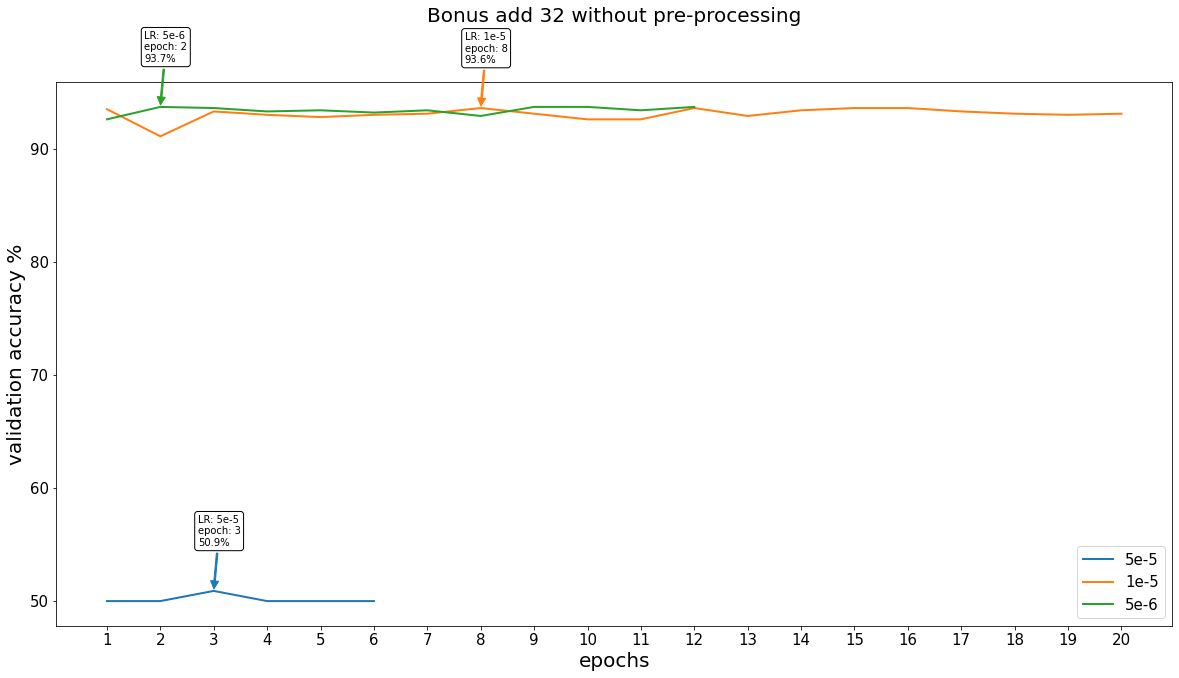

In [ ]:
main_label = "Bonus add 32 without pre-processing"
sub_label = ["5e-5", "1e-5", "5e-6"]
results = [
    [50.0, 50.0, 50.9, 50.0, 50.0, 50.0],
    [93.5, 91.1, 93.3, 93.0, 92.8, 93.0, 93.1, 93.6, 93.1, 92.6, 92.6, 93.6, 92.9, 93.4, 93.6, 93.6, 93.3, 93.1, 93.0, 93.1],
    [92.6, 93.7, 93.6, 93.3, 93.4, 93.2, 93.4, 92.9, 93.7, 93.7, 93.4, 93.7],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("validation accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    ax.annotate(
        f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
        fontsize=10,
        xy=(xmax, ymax),
        xytext=(xmax - 0.3, ymax + 4),
        bbox=dict(boxstyle="round", fc="none", ec="black"),
        arrowprops=dict(
            arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
            color=p[0].get_color(),
        ),
    )
plt.legend(fontsize=15)


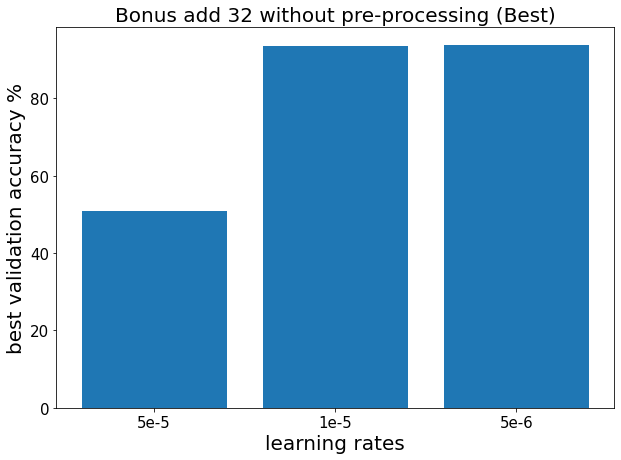

In [ ]:
main_label = "Bonus add 32 without pre-processing (Best)"
x_axis = ["5e-5", "1e-5", "5e-6"]
y_axis = []
for i in range(len(results)):
    ymax = max(results[i])
    y_axis.append(ymax)
fig, ax = plt.subplots(figsize=(10, 7))
ax.tick_params(axis="both", which="major", labelsize=15)
plt.bar(x_axis, y_axis)
plt.title(main_label, fontsize=20)
plt.xlabel("learning rates", fontsize=20)
plt.ylabel("best validation accuracy %", fontsize=20)
plt.show()


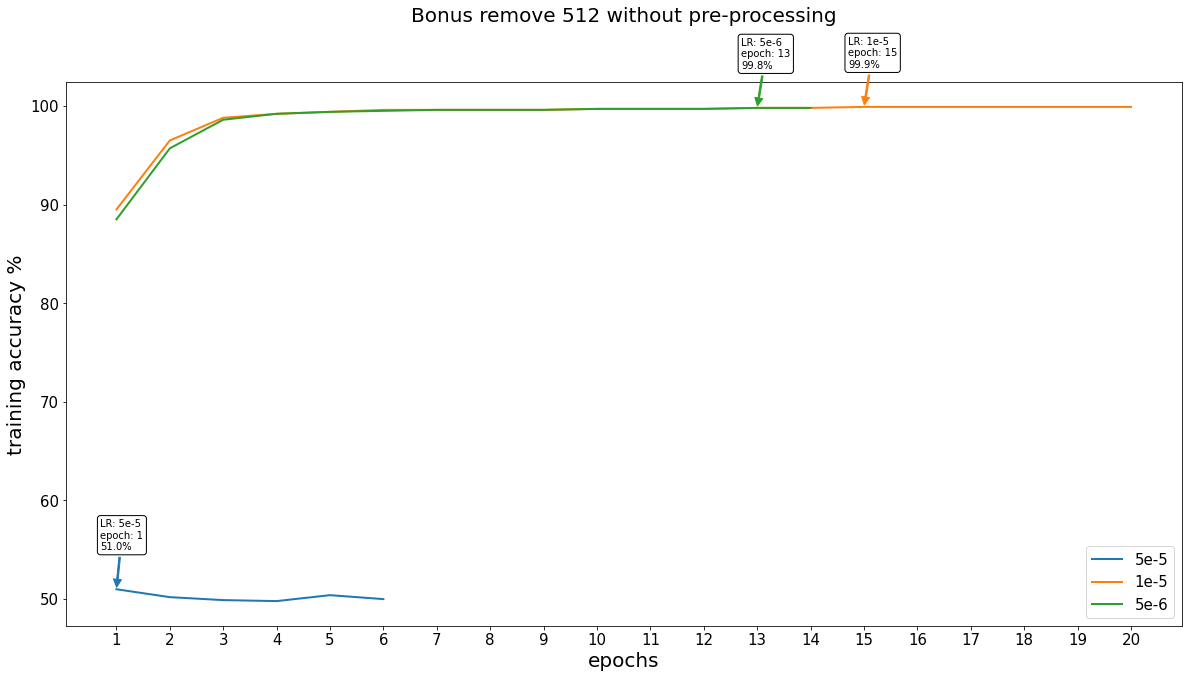

In [ ]:
main_label = "Bonus remove 512 without pre-processing"
sub_label = ["5e-5", "1e-5", "5e-6"]
results = [
    [51.0, 50.2, 49.9, 49.8, 50.4, 50.0],
    [89.5, 96.5, 98.8, 99.2, 99.4, 99.6, 99.6, 99.6, 99.6, 99.7, 99.7, 99.7, 99.8, 99.8, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9],
    [88.5, 95.7, 98.6, 99.2, 99.4, 99.5, 99.6, 99.6, 99.6, 99.7, 99.7, 99.7, 99.8, 99.8],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("training accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    ax.annotate(
        f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
        fontsize=10,
        xy=(xmax, ymax),
        xytext=(xmax - 0.3, ymax + 4),
        bbox=dict(boxstyle="round", fc="none", ec="black"),
        arrowprops=dict(
            arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
            color=p[0].get_color(),
        ),
    )
plt.legend(fontsize=15)


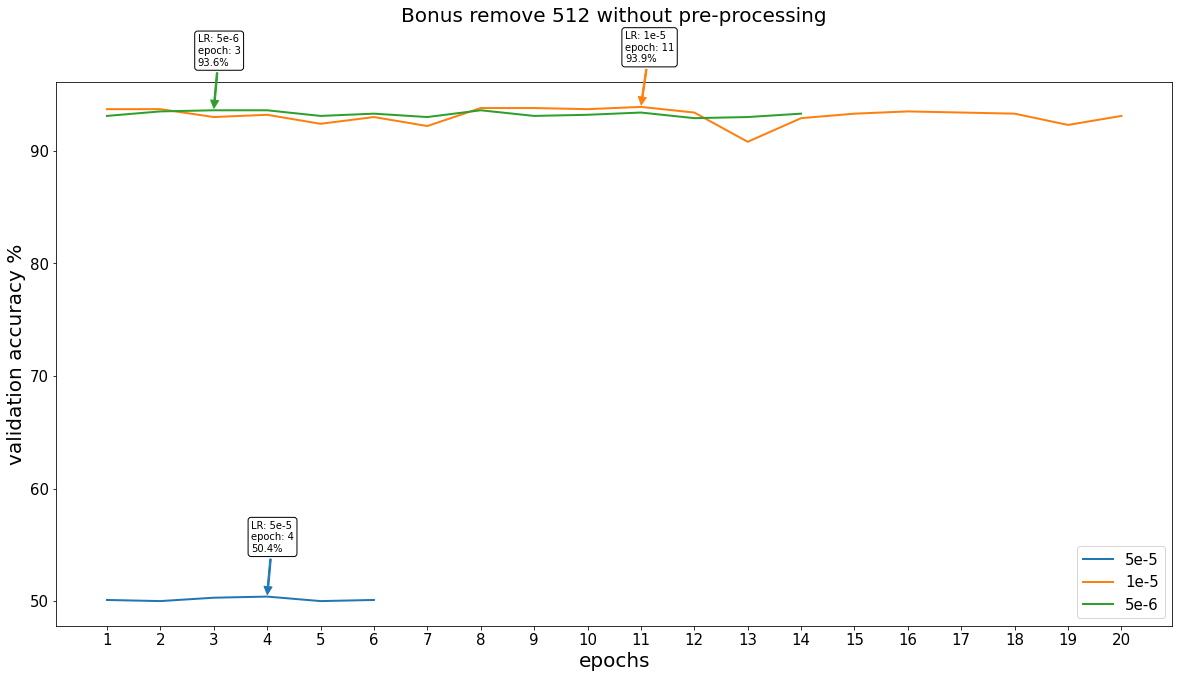

In [ ]:
main_label = "Bonus remove 512 without pre-processing"
sub_label = ["5e-5", "1e-5", "5e-6"]
results = [
    [50.1, 50.0, 50.3, 50.4, 50.0, 50.1],
    [93.7, 93.7, 93.0, 93.2, 92.4, 93.0, 92.2, 93.8, 93.8, 93.7, 93.9, 93.4, 90.8, 92.9, 93.3, 93.5, 93.4, 93.3, 92.3, 93.1],
    [93.1, 93.5, 93.6, 93.6, 93.1, 93.3, 93.0, 93.6, 93.1, 93.2, 93.4, 92.9, 93.0, 93.3],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("validation accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    ax.annotate(
        f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
        fontsize=10,
        xy=(xmax, ymax),
        xytext=(xmax - 0.3, ymax + 4),
        bbox=dict(boxstyle="round", fc="none", ec="black"),
        arrowprops=dict(
            arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
            color=p[0].get_color(),
        ),
    )
plt.legend(fontsize=15)


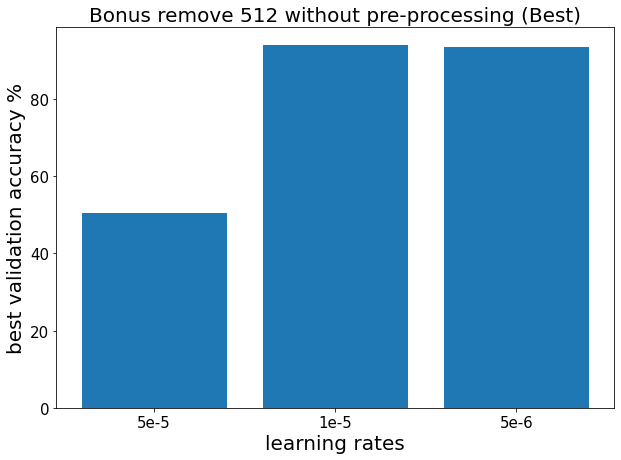

In [ ]:
main_label = "Bonus remove 512 without pre-processing (Best)"
x_axis = ["5e-5", "1e-5", "5e-6"]
y_axis = []
for i in range(len(results)):
    ymax = max(results[i])
    y_axis.append(ymax)
fig, ax = plt.subplots(figsize=(10, 7))
ax.tick_params(axis="both", which="major", labelsize=15)
plt.bar(x_axis, y_axis)
plt.title(main_label, fontsize=20)
plt.xlabel("learning rates", fontsize=20)
plt.ylabel("best validation accuracy %", fontsize=20)
plt.show()


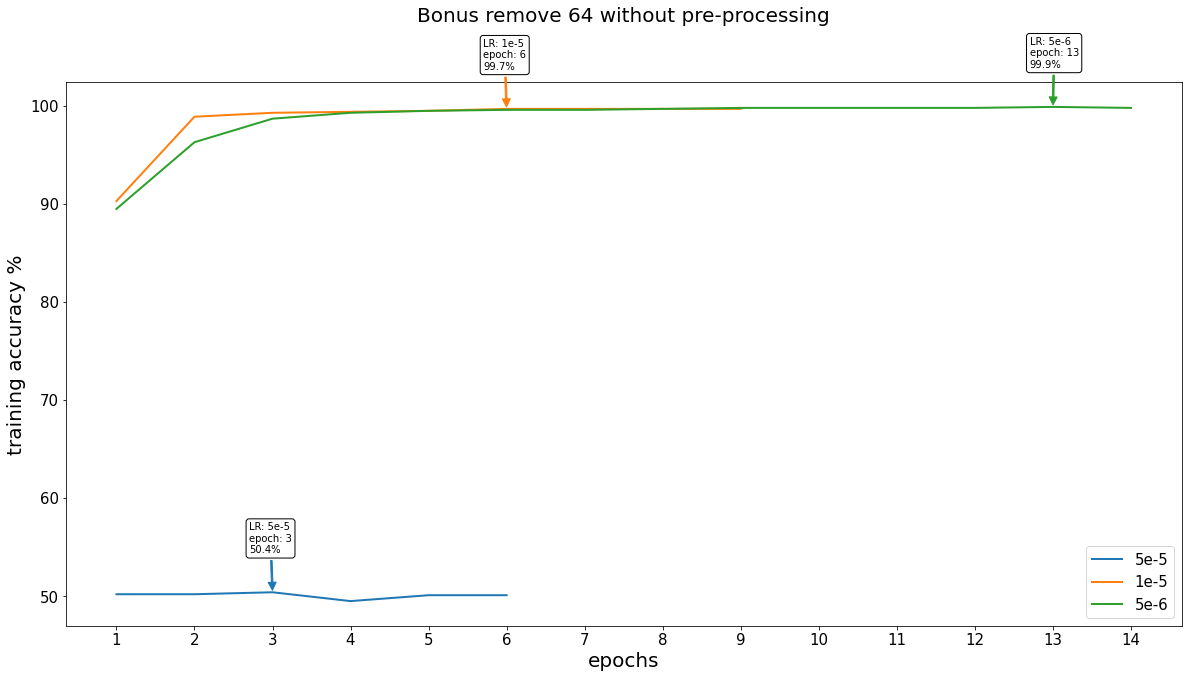

In [ ]:
main_label = "Bonus remove 64 without pre-processing"
sub_label = ["5e-5", "1e-5", "5e-6"]
results = [
    [50.2, 50.2, 50.4, 49.5, 50.1, 50.1],
    [90.3, 98.9, 99.3, 99.4, 99.5, 99.7, 99.7, 99.7, 99.7],
    [89.5, 96.3, 98.7, 99.3, 99.5, 99.6, 99.6, 99.7, 99.8, 99.8, 99.8, 99.8, 99.9, 99.8],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("training accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    ax.annotate(
        f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
        fontsize=10,
        xy=(xmax, ymax),
        xytext=(xmax - 0.3, ymax + 4),
        bbox=dict(boxstyle="round", fc="none", ec="black"),
        arrowprops=dict(
            arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
            color=p[0].get_color(),
        ),
    )
plt.legend(fontsize=15)


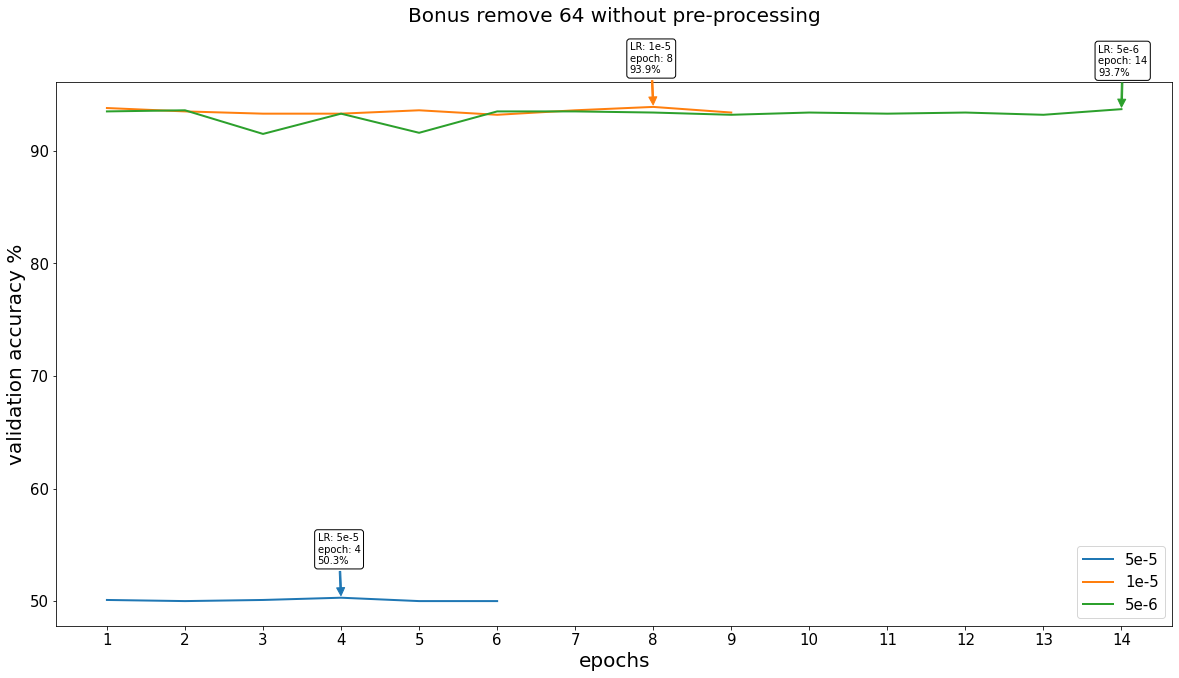

In [ ]:
main_label = "Bonus remove 64 without pre-processing"
sub_label = ["5e-5", "1e-5", "5e-6"]
results = [
    [50.1, 50.0, 50.1, 50.3, 50.0, 50.0],
    [93.8, 93.5, 93.3, 93.3, 93.6, 93.2, 93.6, 93.9, 93.4],
    [93.5, 93.6, 91.5, 93.3, 91.6, 93.5, 93.5, 93.4, 93.2, 93.4, 93.3, 93.4, 93.2, 93.7],
]

fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(1, len(max(results, key=len)) + 1))
plt.xlabel("epochs", fontsize=20)
plt.ylabel("validation accuracy %", fontsize=20)
plt.title(main_label, y=1.1, fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=15)


for i in range(len(results)):
    y = results[i]
    x = range(1, len(y) + 1)
    xmax = x[np.argmax(y)]
    ymax = max(y)
    p = plt.plot(x, y, label=sub_label[i], linewidth=2)

    ax.annotate(
        f"LR: {sub_label[i]}\nepoch: {xmax}\n{ymax}%",
        fontsize=10,
        xy=(xmax, ymax),
        xytext=(xmax - 0.3, ymax + 3),
        bbox=dict(boxstyle="round", fc="none", ec="black"),
        arrowprops=dict(
            arrowstyle="simple,head_length=0.8 ,head_width=0.8,tail_width=0.15",
            color=p[0].get_color(),
        ),
    )
plt.legend(fontsize=15)


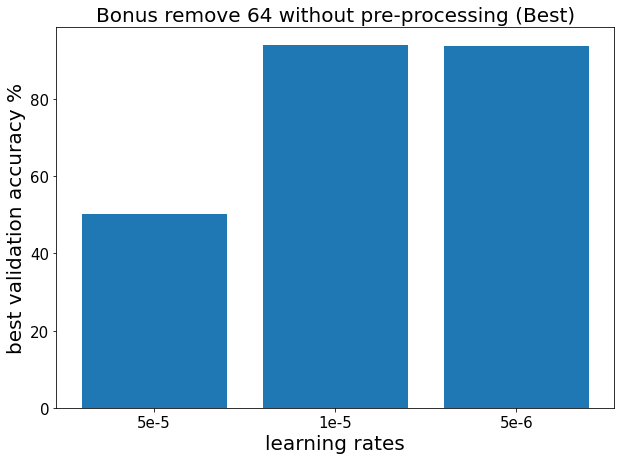

In [ ]:
main_label = "Bonus remove 64 without pre-processing (Best)"
x_axis = ["5e-5", "1e-5", "5e-6"]
y_axis = []
for i in range(len(results)):
    ymax = max(results[i])
    y_axis.append(ymax)
fig, ax = plt.subplots(figsize=(10, 7))
ax.tick_params(axis="both", which="major", labelsize=15)
plt.bar(x_axis, y_axis)
plt.title(main_label, fontsize=20)
plt.xlabel("learning rates", fontsize=20)
plt.ylabel("best validation accuracy %", fontsize=20)
plt.show()


Models with the best validation accuracy are [add 1024 5e-6, remove 512 1e-5, remove 64 1e-5] at 93.9%, will pick add 1024 5e-6 epoch 2 as it has the lowest validation loss at 0.021 (vs 0.037 and 0.036)

*Testing best model (add 1024 5e-6 epoch 2)*

In [ ]:
batch_s = 8
torch.manual_seed(SEED)
def seed_worker(worker_id):
    np.random.seed(SEED)
    random.seed(SEED)

test = Dataset(df_test)
test_dataloader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_s,
    worker_init_fn=seed_worker,
)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

path = '/content/drive/MyDrive/models/no_preprocessing/bonus/'
model = torch.load(f'{path}add1024_5e-06_epoch2')
model.eval()
all_y_pred = []
for test_input, test_label in test_dataloader:
    test_label = test_label.to(device)
    mask = test_input["attention_mask"].to(device)
    input_id = test_input["input_ids"].squeeze(1).to(device)
    with torch.no_grad():
        y_pred = model(input_id, mask)
    y_pred = torch.flatten(y_pred)
    y_pred = torch.round(y_pred)
    all_y_pred.append(y_pred)
    
all_y_pred = torch.cat(all_y_pred, dim=0)


Accuracy: 93.53%
Precision: 0.932
recall: 0.939
specificity: 0.931
f1-score: 0.936


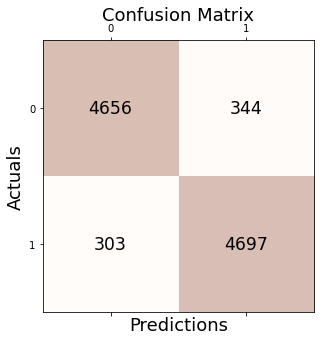

In [ ]:
y_pred = all_y_pred.cpu()

print(f"Accuracy: {metrics.accuracy_score(y_test_num, y_pred)*100:.2f}%")

scores_pos = metrics.precision_recall_fscore_support(
    y_test_num, y_pred, average=None, labels=[1]
)
precision = scores_pos[0][0]
recall = scores_pos[1][0]
f1score = scores_pos[2][0]
specificity = metrics.precision_recall_fscore_support(
    y_test_num, y_pred, average=None, labels=[0]
)[1][
    0
]  # specificity is recall of negative class

print(f"Precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"specificity: {specificity:.3f}")
print(f"f1-score: {f1score:.3f}")

conf_matrix = metrics.confusion_matrix(y_true=y_test_num, y_pred=y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(
            x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large"
        )
plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()


Slightly worse results than best model, did not improve using the tested different structure.